In [8]:
import sys, warnings, os
import scanpy as sc 
import numpy as np
import pandas as pd
import h5py
import csv
from scipy import sparse, linalg, stats
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix 
from scipy.linalg import ishermitian
from scipy import sparse
import time
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")



In [9]:
def replace_features(data, features):
    
    tmp_obs = []
    for iobs in data.obs_names:
        #print(iobs,features.x[int(iobs)])
        tmp_obs.append(features.x[int(iobs)])
        
    data.obs_names = tmp_obs
    
def save_h5file(arr,fname):
    ''' save_h5file stores the full array size to fname
    '''
    h5f = h5py.File(fname+".h5", 'w')
    #sarr = sparse.csr_matrix(arr)
    #h5f.create_dataset(fname, data=sarr)
    h5f.create_dataset(fname, data=arr)
    h5f.close()
    
def read_eigen_h5(fname1, fname2) : 
    ''' read_eigen_h5 reads the full array size from h5 file
    '''
    f = h5py.File(fname1,"r")
    keys = np.asarray( list( f.keys()   ))
    S = np.asarray( list( f[keys[0]] ))
    #S = S.toarray()
    f.close()

    f = h5py.File(fname2,"r")
    keys  = np.asanyarray( list( f.keys()   ) )
    S2 = np.asanyarray( list( f[keys[0]] ) )
    #S2 = S2.toarray()
    f.close()
    
    return S, S2

def get_evalh5_diff_indices(fname1, fname2):
    ''' Get eigenvalues main differences '''
    f = h5py.File("Sgene.h5","r")
    keys = np.asarray( list( f.keys()   ))
    data = np.asarray( list( f[keys[0]] ))
    f.close()
    
    f = h5py.File("Sgene2.h5","r")
    keys  = np.asanyarray( list( f.keys()   ) )
    data2 = np.asanyarray( list( f[keys[0]] ) )
    kmin = min(len(data),len(data2))
    f.close()
    
def norm_vecs(X, form) :
    
    if form == "gene":
        # Number of columns 
        n = len( X[0,:] )
        for i in range(n): 
            # Normalize columns 
            X[:,i] = X[:,i]/np.linalg.norm(X[:,i])
        
    elif form == "cell" : 
        # Number of rows
        n = len( X[:,0] )
        for i in range(n): 
            # Normalize rows
            X[i,:] = X[i,:]/np.linalg.norm(X[i,:])
            
    return X

# Compute eps/threshold in bisection wise
def bisec_f(arr, min_id, max_id):
    ''' This function will execute the bisection algorithm to find
        the range (max,min) of an array within 20% difference
    INPUT: 
    max_id -> Max position to look in the array
    min_id -> Min position to look in the array
    arr    -> Array to bisect
    OUTPUT:
    maxval -> Maximum value of the bisection
    minval -> Minimum value of the bisection
    eps    -> Difference of the max and min values of bisection    
    '''
    
    icon = 0
    thrsh = max(arr)*0.20 
    finished = True
    while finished :
        icon += 1
        mid  = int( min_id + (max_id - min_id )/2 )
        plus = int( min_id + (max_id - min_id )*3/4)
        minu = int( min_id + (max_id - min_id )/4)
       
        #print(min_id,minu,mid,plus,max_id)
        #print(arr[min_id],arr[minu],arr[mid],arr[plus],arr[max_id])

        mid_old = mid
        if arr[mid] < arr[plus]: 
            # Simple search
            min_id = mid

        elif arr[mid] < arr[minu] :
            # Simple search
            max_id = mid 
            
        elif (arr[min_id] + arr[minu] + arr[mid])/3 > (arr[max_id] + arr[plus] + arr[mid])/3 :
            # Refined search
            max_id = mid
            
        else :
            min_id = mid
            
        minval = arr[min_id]
        maxval = arr[max_id]
        eps = abs(maxval - minval)
              
        if eps < thrsh : 
            finished = False
            return minval, maxval, eps
        
        if icon >= len(arr) :
            finished = False

    
def plot_cov_eval(imode, S, S2) :
    ''' plot_cov_eval plots the eigenvalues and its difference
    INPUT: 
    imode -> mode as cell or gene
    S     -> Eigenvalue set 1
    S2    -> Eigenvalue set 2
    OUTPUT:
    Figures -> imode_cov_spectra.png, imode_cov_diff_spectra.png 
    '''
    
    kmax  = len(S)
    kmax2 = len(S2)
    ptitle = "Log10 plot of "+ imode +" covariance eigenvalues"
    plt.title(ptitle)
    plt.xlim(-100, max(kmax,kmax2) )
    plt.plot(range(kmax), np.log10(S), color='red', lw=2, label="dataset1",alpha=0.2)
    plt.plot(range(kmax2), np.log10(S2), color='blue', lw=2, label="dataset2",alpha=0.2)
    
    plt.legend(loc='upper right', fancybox=True)
    sname = imode + "_cov_spectra.png"
    plt.savefig(sname)
    plt.clf()
    
    # Difference of Eigenvalues
    kmin = min(kmax,kmax2)
    diff1 = np.log10(S[0:kmin]) - np.log10(S2[0:kmin])

    ptitle = "Log10 plot of "+ imode + " covariance eigenvalue differences"
    plt.title(ptitle)
    plt.xlim(-100, kmin )
    plt.plot(range(kmin), diff1, color='red', lw=2)
    sname = imode + "_cov_spectra_diff.png"
    plt.savefig(sname)
    plt.clf()
    

def read_mex(bname,fname,mname) :
    ''' read_mex read Market Exchange file format and 
        returns the Matrix data with features replaced
    INPUT : 
    bname -> barcode name file
    fname -> feature name file
    mname -> matrix name file
    OUTPUT :
    data  -> matrix with annotated features
    '''
    barcodes = pd.read_csv(bname, sep='\t')
    features = pd.read_csv(fname, sep='\t')
    data = sc.read_mtx(mname)  
    replace_features(data,features)
    
    return data

    
def gene_cov_space(data, data2, fsparse = False, imode = "gene", norm = False) : 
    # imode = "gene" or "cell"

    print("Working in mode : ", imode,"|  Norm :",norm)
    data.var_names_make_unique()
    sc.pp.filter_cells(data, min_genes=500)
    sc.pp.filter_genes(data, min_cells=200)
    sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)

    data2.var_names_make_unique()
    sc.pp.filter_cells(data2, min_genes=500)
    sc.pp.filter_genes(data2, min_cells=200)
    sc.pp.calculate_qc_metrics(data2, percent_top=None, log1p=False, inplace=True)

    if not fsparse :
        # Full format
        X = data.X.toarray()
        X2 = data2.X.toarray()
        #print("X Features and cells number :", data.X.n_vars, data.X.n_obs)
        print("Shape of cleaned X : ", X.shape)
        #print("X2 Features and cells number :", data2.X.n_vars, data2.X.n_obs)
        print("Shape of cleaned X2 : ", X2.shape)
        
        #if norm :
        #    X  = norm_vecs(X, form = imode)
        #    X2 = norm_vecs(X2, form = imode)
        
        if imode == "cell" :
            # Cells description
            A  =  np.matmul(X,X.transpose()) 
            A2 =  np.matmul(X2,X2.transpose()) 

        elif imode == "gene" :
            # Genes
            A  =  np.matmul(X.transpose(),X) 
            A2 =  np.matmul(X2.transpose(),X2) 
        else :
            print("Mode "+imode+" not recognized")
            print("Valid modes are gene or cell")
            return
        
        print("A shape : ", A.shape)
        print("A2 shape : ", A2.shape)
        kmax  = min(A.shape)
        kmax2 = min(A2.shape)
        
        # Clean memory
        X = None
        X2 = None

        isHerm  = ishermitian(A)
        isHerm2 = ishermitian(A2)
        print("Are Hermitian : ",str(isHerm),str(isHerm2))
        print("Processing A1")
        [U, S, Vh] = np.linalg.svd(A, hermitian=isHerm)
        set1 = [S, Vh]
        U  = None
        Vh = None
        A  = None
        
        print("Processing A2")
        [U2, S2, Vh2] = np.linalg.svd(A2, hermitian=isHerm2)
        set2 = [S2, Vh2]
        U2  = None
        Vh2 = None
        A2 = None        

        # Plot 
        plot_cov_eval(imode, S, S2)

        S  = None
        S2 = None
        
        if imode == "cell" :
            fname  = ["Scell",  "Vcell" ]
            fname2 = ["Scell2", "Vcell2"]
        elif imode == "gene" :
            fname  = ["Sgene",  "Vgene" ]
            fname2 = ["Sgene2", "Vgene2"]

        for i in range(2) : 
            save_h5file(set1[i], fname[i])
            save_h5file(set2[i], fname2[i])
            
        print("Getting highly different indices")
        hdi, diff = get_diff_evals(set1[0], set2[0])
        
        print("Computing Chi_dens")
        plot_name = "chi_dens12_"+imode
        chi_dens = get_chidens(set1[0], set1[1], set2[0], set2[1], hdi, plot_name)

    else : 
        # WORK IN SPARSE FORMAT
        X = data.X.toarray()
        X = csr_matrix(X)
        # Cells
        #A = X*X.T 
        # Genes
        A = X.T*X
        X = None
        #isHerm = ishermitian(A)
        #print("data.X matrix is Hermitian : ", str(isHerm))
        #kmax = min(A.shape)-1
        kmax = 6 # Python default
        print(kmax)
        [U, S, Vh] = svds( A, k=kmax)




In [10]:
def get_diff_evals(S1, S2) :
    ''' Compute the most different eigenvalues to analyze
    INPUT:
    S1 ------> First set of eigenvalues 
    S2 ------> Second set of eigenvalues 
    imode ---> Defines either Cell or gene mode
    read_hd5-> boolean to read from file or not the eigenvalues
    OUTPUT:
    hdi------> highly different indices 
    diff-----> difference of the eigenvalues in log form
    '''
        
    # Define which eigenvector set is smaller to work on
    kmin = min(len(S1),len(S2))
    print("S1 Max-val :", S1.max())
    print("S2 Max-val :", S2.max())
    print("S1 Min-val :", S1.min())
    print("S2 Min-val :", S2.min())
    
    # Log10 difference of the eigenvalues to have smoother landscape
    diff = np.log10(S1[0:kmin]) - np.log10(S2[0:kmin])
    
    # Look through bisection algorithm the highest different region
    m = len(diff)
    info = bisec_f(diff, 0, m-1)
    eps = info[0]
    print("Bisected information : ",info[0:2])
    # Extract the indices where hdi matters
    hdi = list( np.where( diff > eps)[0] )

    diff = diff[hdi]
    kval = len(diff)
    
    plt.title("Log plot of highly different \n gene covariance eigenvalues")
    plt.plot(range(kval), diff, color='red', lw=2)
    plt.savefig('cov_hdi.png')
    plt.clf()
    
    return hdi, diff

def get_chidens(S1, V1, S2, V2, hdi, plot_name):
    ''' get_chidens computes the density within two eigen-spaces. 
        The main idea resides in S1*V1 (S2*V2), where S is 
        the finger print (eigenvalue) of 
        the eigen-space and V1 is the eigen-vector.
    INPUT:
    S1 -------> Eigenvalue set 1
    S2 -------> Eigenvalue set 2
    V1 -------> Eigenvectors from set 1
    V2 -------> Eigenvectors from set 2
    plot_name-> Name for png image
    read_hd5 -> read from files
    OUTPUT:
    chi_dense -> Chi density is a matrix that contains <SV1|SV2> 
                 and describes how much the two spaces overlap within a hdi.
                 it's density given that is weighted overlap.
    '''
    S = np.diag(S1)
    SV1 = np.matmul(S,V1)

    S = np.diag(S2)
    SV2 = np.matmul(S,V2)

    S = None

    # Vg[:,hdi] is chi matrix for largely differenciated principal componets
    # Chi dense is the overlap of the meta space for the gene covariance matrix of different samples
    chi_dens = np.matmul(SV1[:,hdi], SV2[:,hdi].transpose())

    SV1 = None
    SV2= None
            
    neg_range = np.where(chi_dens < 0)
    chi_dens = abs(chi_dens)

    # Log transformation with shift
    chi_denslog = np.log10(chi_dens + 1)
    # Anything around 0 (log(x+1) <= 0) can be rounded to 0
    chi_denslog[chi_denslog <= 0] = 0
    
    sns.set()
    #colormap = sns.color_palette("viridis", as_cmap=True)
    #colormap = sns.color_palette("Spectral", as_cmap=True)
    #colormap = sns.color_palette("flare", as_cmap=True)
    #colormap = sns.color_palette("crest", as_cmap=True)    
    colormap = sns.color_palette("rocket", as_cmap=True)


    # Negative phase
    chi_denslog[neg_range] = -1.0*chi_denslog[neg_range]
    
    ax = sns.heatmap(chi_denslog, vmin=None, vmax=None, cmap=colormap)
    
    plt.title("Heatmap Chi_density")
    plt.savefig("heat_map_"+plot_name+".png")
    plt.clf()

    return chi_denslog

In [11]:
fname  = '10k_hgmm_3p_nextgem_Chromium_X_filtered_feature_bc_matrix.h5'
fname2 = '20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5'

#os.chdir('C:\\Users\\ssromerogon\\Documents\\cell_diff\\dog_cells\\tmp3\\')
data  = sc.read_10x_h5(fname)
data2 = sc.read_10x_h5(fname2)  

gene_cov_space(data, data2, fsparse = False, imode = "gene") 
gene_cov_space(data, data2, fsparse = False, imode = "cell") 

Working in mode :  gene |  Norm : False


KeyboardInterrupt: 

In [5]:
read_eigen = True
imode = "gene"

if read_eigen :
    if imode == "gene":
        fname1 = "Vgene.h5"
        fname2 = "Vgene2.h5"
        fname3 = "Sgene.h5"
        fname4 = "Sgene2.h5"
            
    elif imode == "cells":
        fname1 = "Vcell.h5"
        fname2 = "Vcell2.h5"
        fname3 = "Scell.h5"
        fname4 = "Scell2.h5"
            
    V1, V2 = read_eigen_h5(fname1, fname2) 
    S1, S2 = read_eigen_h5(fname3, fname4) 


In [82]:
read_eigen = True
imode = "gene"

if read_eigen :
    if imode == "gene":
        fname1 = "Vgene.h5"
        fname2 = "Vgene2.h5"
        fname3 = "Sgene.h5"
        fname4 = "Sgene2.h5"
            
    elif imode == "cells":
        fname1 = "Vcell.h5"
        fname2 = "Vcell2.h5"
        fname3 = "Scell.h5"
        fname4 = "Scell2.h5"
            
    V1, V2 = read_eigen_h5(fname1, fname2) 
    S1, S2 = read_eigen_h5(fname3, fname4) 

# Plotting hdi region eigenvalues
hdi, diff = get_diff_evals(S1, S2) 

# Computing density
plot_name = 'chi_dens12'
chi_denslog = get_chidens(S1, V1, S2, V2, hdi, plot_name)
plot_name = 'chi_dens11'
chi_denslog11 = get_chidens(S1, V1, S1, V1, hdi, plot_name)
plot_name = 'chi_dens22'
chi_denslog22 = get_chidens(S2, V2, S2, V2, hdi, plot_name)

Bisected information :  (0.14716196, 0.15081167)


<Figure size 640x480 with 0 Axes>

In [95]:
def get_gene_relation(fnameg2, data, data2, chi_denslog) : 
    ''' get_gene_relation obtains the relationship stablished from 
        chi_denslog and two gene lists.
        NOTE: data1 and data2 must have the correct annotations
        INPUT:
        fnameg2 -----> gene-gene relation file name
        data   ------> data1 feature names
        data2  ------> data2 feature names
        chi_denslog -> Density metric defined as log10(SV1 * SV2^T)
                       SV = Eigenvalue * Eigenvector is the highly different (weighted) vector space
        OUTPUT:
        g2_rela -----> Gene-Gene relationship extracted from chi_denslog (written to 'g2_relationship.csv')
    '''
    # Setting range for gene lists
    max_chi = chi_denslog.max()
    sub_samp = max_chi/3 # Slicing in 3 sections, low, mid and high
    # Down-regulated
    #low_range = np.where(chi_denslog <= sub_samp)
    # Saddle point
    #mid_range = np.where( np.logical_and(chi_denslog < 2*sub_samp, chi_denslog > sub_samp) )
    # Up-regulated
    high_range = np.where(chi_denslog >= 2*sub_samp)
    
    n = len(high_range[0])
    
    # Writting the covariance matrix information log10(SV1 * SV2^T) = chi_denslog (Density_like metric)
    # SV = Eigenvalue * Eigenvector is the highly different (weighted) vector space
    g2_rela = []
    for i in range(n) :
        irow = high_range[0][i]
        jcol = high_range[1][i]
        # getting information : G1_name, G2_name, Density_based_value
        g2_rela.append( [ data.obs_names[irow], data2.obs_names[jcol], chi_denslog[ irow, jcol ] ])

    col_name = ['Gene_set1', 'Gene_set2', 'Density metric']
    g2_rela = pd.DataFrame(g2_rela,columns = col_name)
    g2_rela.to_csv('g2_relationship.csv') 
    
    return g2_rela, high_range


def get_dens_score(fname, data, high_range, g2_rela, mode):
    ''' get_dens_score will compute a score based on the eigenvecor * eigenvalue metric
        denoted as density here in log form (chi_denslog). 
        INPUT : 
        fname ------> file name
        data  ------> data containing feature names
        high_range -> indeces of largest values of chi_denslog
        mode -------> mode to access gene set in g2_rela
        g2_rela ----> most meaningful relationship within genes 
                      of sample X1 and sample X2 mapped from chi_denslog
        OUTPUT :
        df_score ---> dataframe containing gene1, gene2, score (from chi_denslog)
    '''
    
    col_name = [mode, 'score']
    score = []
    gname_old = 'NONE'
    n = len(data.obs_names[ high_range ] )
    for i in range(n):
        gname = data.obs_names[ high_range[i] ]
        #print(gname)
        # Sum over not repeated gene names
        if not gname == gname_old :
            tmp = g2_rela[ g2_rela[col_name[0]] == gname ]
            score.append( [ gname, tmp['Density metric'].sum() ] )
        gname_old = gname  
    
    df_score = pd.DataFrame(score, columns = col_name)
    df_score.to_csv(fname) 
    
    plt.bar(df_score[ col_name[0] ][0:38], df_score[ col_name[1] ][0:38], color='skyblue')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
    plt.title('Bar Plot of Gene Set Scores')
    plt.xlabel('Gene Set', fontsize=8 )
    plt.ylabel('Score')
    plt.tight_layout()  # Adjust layout for better visualization
    plt.savefig('score_'+str(mode)+'_plot.png')
    plt.clf()

    return df_score
    


In [100]:
fname  = 'data_h.h5'
fname2 = 'data_t.h5'

os.chdir('C:\\Users\\ssromerogon\\Documents\\cell_diff\\dog_cells\\tmp3\\')
data  = sc.read_10x_h5(fname)
data2 = sc.read_10x_h5(fname2)  

fnameg2 = 'g2_relation12.csv'
g2_rela, high_range = get_gene_relation(fnameg2, data, data2, chi_denslog) 

fname = 'g1_score12.csv'
df_score1 = get_dens_score(fname, data, high_range[0], g2_rela, mode='Gene_set1')

fname = 'g2_score12.csv'
df_score2 = get_dens_score(fname, data2, high_range[1], g2_rela, mode='Gene_set2')


<Figure size 640x480 with 0 Axes>

In [99]:
fname  = 'data_h.h5'
fname2 = 'data_t.h5'

os.chdir('C:\\Users\\ssromerogon\\Documents\\cell_diff\\dog_cells\\tmp3\\')
data  = sc.read_10x_h5(fname)
data2 = sc.read_10x_h5(fname2)  

fnameg2 = 'g2_relation11.csv'
g2_rela, high_range = get_gene_relation(fnameg2, data, data, chi_denslog) 

fname = 'g1_score11.csv'
df_score1 = get_dens_score(fname, data, high_range[0], g2_rela, mode='Gene_set1')




<Figure size 640x480 with 0 Axes>

In [52]:
plt.bar(df_score1['Gene_set'][0:38], df_score1['score'][0:38], color='skyblue')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title('Bar Plot of Gene Set Scores')
plt.xlabel('Gene Set', fontsize=8 )
plt.ylabel('Score')
plt.tight_layout()  # Adjust layout for better visualization
plt.savefig('geneset1_score.png')

KeyError: 'Gene_set1'

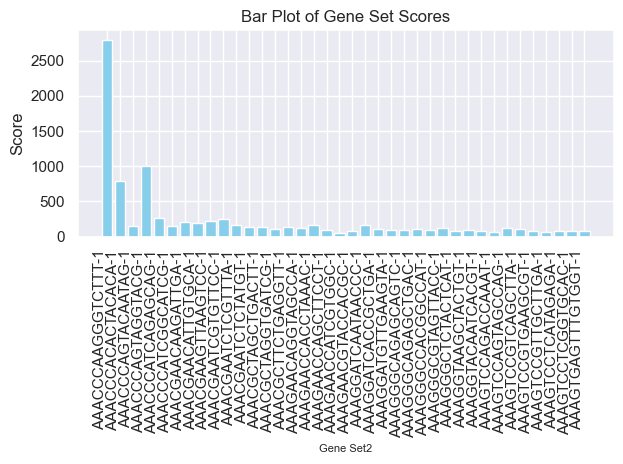

In [47]:
plt.bar(df_score2['Gene_set2'][0:38], df_score2['score'][0:38], color='skyblue')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.title('Bar Plot of Gene Set Scores')
plt.xlabel('Gene Set2', fontsize=8 )
plt.ylabel('Score')
plt.tight_layout()  # Adjust layout for better visualization
plt.savefig('geneset2_score.png')

In [48]:
# Differential expressed scores from densities
n = len(df_score1.Gene_set1)
m = len(df_score2.Gene_set2)
diff_exp = []

for ig in range(n):
    for jg in range(m):
        #print(ig,jg,df_score1.Gene_set1[ig], df_score2.Gene_set2[jg] )
        if df_score1.Gene_set1[ig] == df_score2.Gene_set2[jg] :
            #print("****",ig,jg,df_score1.Gene_set1[ig], df_score2.Gene_set2[jg] )
            diff = df_score1.score[ig] - df_score2.score[jg]
            diff_exp.append( [df_score2.Gene_set2[jg], diff] )

In [56]:
chi_denslog = np.log10(chi_dens12 + 1)

fnameg2 = 'g2_relation12.csv'
g2_rela = get_gene_relation(fnameg2, data, data2, chi_denslog) 

max_chi = chi_denslog.max()
sub_samp = max_chi/3 # Slicing in 3 sections, low, mid and high
high_range = np.where(chi_denslog >= 2*sub_samp)

fname = 'g1_score12.csv'
df_score1 = get_dens_score(fname, data, high_range[0], g2_rela)
#df_score1.score = np.log10(df_score1.score)

fname = 'g2_score12.csv'
df_score2 = get_dens_score(fname, data2, high_range[1], g2_rela)
#df_score2.score = np.log10(df_score2.score)

TypeError: tuple indices must be integers or slices, not str

In [61]:
    
col_name = ['Gene_set', 'score']
score = []
gname_old = 'NONE'
n = len(data.obs_names[ high_range[0] ] )
for i in range(n):
    gname = data.obs_names[ high_range[0][i] ]
    print(gname)
    # Sum over not repeated gene names
    if not gname == gname_old :
        tmp = g2_rela[ g2_rela[col_name[0] == gname ]
        score.append( [ gname, tmp['Density metric'].sum() ])
    gname_old = gname  
    
df_score = pd.DataFrame(score, columns = col_name)
    

SyntaxError: invalid syntax (1554963876.py, line 11)

In [ ]:
# Differential expressed scores from densities
n = len(df_score1.Gene_set1)
m = len(df_score2.Gene_set2)
diff_exp = []

for ig in range(n):
    for jg in range(m):
        #print(ig,jg,df_score1.Gene_set1[ig], df_score2.Gene_set2[jg] )
        if df_score1.Gene_set1[ig] == df_score2.Gene_set2[jg] :
            #print("****",ig,jg,df_score1.Gene_set1[ig], df_score2.Gene_set2[jg] )
            diff = df_score1.score[ig] - df_score2.score[jg]
            diff_exp.append( [df_score2.Gene_set2[jg], diff] )


17.116768

In [48]:
np.log10(chi_dens.max())

17.226862

In [ ]:
da